### Throwback: which SNPs are associated with mouse hair color again?

Remember the GWAS task, where we investigated which SNPs were significantly associated with the coat color of mice? Machine learning ties in well with this task. We know random forests are useful to determine the importance of different features when classifying samples. We could ask a random forest to predict hair color from genotype data, and then look at what features it considered important while doing it.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict
from sklearn import metrics as sme

Load the genotype and color data. Make sure you index the genotype data explicitly by passing `index_col="Locus"` to the csv reader.

In [2]:
genotype = pd.read_csv("files/dataS4.txt", sep="\t", comment="@", index_col="Locus")
colors = pd.read_csv("files/phenotype.csv", index_col=0, names=["color"], na_values='x').dropna()['color']

In [3]:
colors.head()

C57BL/6J    4.0
DBA/2J      1.0
B6D2F1      4.0
D2B6F1      4.0
BXD1        1.0
Name: color, dtype: float64

Split the genotype data into two dataframes: one should contain the metadata (first 3 columns) and the other the actual genotype data. Call them `geno_metadata` and `geno`.

Remember, `sklearn` takes samples in rows, and our samples correspond to mice strains here, so transpose `geno`. Also make sure that the indices of the `geno` and `color` DFs line up with each other: only keep the intersection of their indices. Index objects support intersection.

In [4]:
geno_metadata = genotype.iloc[:, :3]
geno = genotype.iloc[:,3:].T


In [5]:
geno.index.intersection(colors.index)

colors = colors.loc[geno.index.intersection(colors.index)]
geno = geno.loc[geno.index.intersection(colors.index)]

geno.shape

(90, 3811)

Encode the B/D/H/U genotype information with numbers. You can use -1/0/0/1 or 0/1/1/2 for B/H/U/D respectively. Either way, it's best to encode H with a value between B and D since it stands for hybrid.

As for encoding colors: they are already numbers. We won't even transform them to the binary black/non-black labels like we did on day 3, we will just feed it them to the predictor as they are. Let the random forest figure out the associations for black/grey/white/brown.

In [6]:
#Again use a dictionary for encoding
encode = {'B' : 0, 'D' : 2, 'H': 1, 'U' : 4}
geno_enc = geno

geno_enc = geno_enc.applymap(encode.get)
geno_enc.shape

(90, 3811)

Train a random forest classifier with all the data. Make sure you use a lot of trees in that forest (a few thousand should be good) so we can get fine-grained values for feature importances. The more decision trees you run the data on, the clearer it gets which features it tests most often.

In [7]:
#Init randomforest classifier and train it on the the encoded coat color data
clf = RandomForestClassifier(n_estimators=10000, random_state=0)
clf.fit(geno_enc, colors)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10000, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

Now take the feature importance vector, and add it to the `geno_metadata` DataFrame as a new column. Sort by that column (obviously descending), and look at the most important SNP ids. Compare them with your GWAS data -- no need to load anything, just look at the Manhattan plot from day 3.

In [8]:
#Add the importance of the gene to the table
importances = pd.Series(clf.feature_importances_ , index = geno_metadata.index)
geno_metadata['importance'] = importances

#Sort it desecending to the importance -> small p-value = highly significant
geno_metadata_sorted = geno_metadata.sort_values('importance', ascending=False)
geno_metadata_sorted.head(30)

,Chr,cM,Mb,importance
Locus,,,,
rs13477796,4,41.281,78.698063,0.014040
rs3708061,4,41.281,80.950126,0.013557
rs13480283,9,45.892,75.877786,0.013221
rs3685573,9,46.179,76.102533,0.012773
rs3658567,4,40.995,76.484833,0.012424
rs3724833,9,45.892,74.735876,0.012305
rs3725904,9,46.179,76.983761,0.011707
rs13480279,9,45.606,74.382952,0.011604
rs3670437,9,45.319,73.954057,0.011074


It is mentionable that all the important features, or at least the 30 most important ones, are located either on chromosom 4 or on chromosome 9. This is interesting, since if we look at the Manhatten plot of Day 3, then those were also the two most significant chromosoms for differential expression. So it seems like the results are correct.

If you took the effort to load that mouse genotype and color data, you might as well take a peek at the performance of the predictor. Calculate a cross-validated accuracy score, and create a confusion matrix for the four colors. You can lower the number of trees used by an order of magnitude, since cross-validation makes things more time intensive.

In [12]:
#Train classifiert with only 100 trees, to speed things up
clf_sparse = RandomForestClassifier(n_estimators= 100)

results_sparse = cross_val_predict(clf_sparse, geno_enc, colors, cv = StratifiedKFold(3, shuffle=True))

sme.confusion_matrix(results_sparse, colors)
# Numbers are tn, fp, fn, tp for each label

array([[30,  4,  2,  0],
       [ 0, 19,  0,  2],
       [ 0,  0, 13,  2],
       [ 0,  0,  3, 15]])

And finally, create a ROC diagram. You know how to make them for binary classifiers... but this isn't a binary classification task. What should it look like when you have 4 labels instead of just 2?

In [13]:
cv_probs = cross_val_predict(clf_sparse, geno_enc, colors, cv = StratifiedKFold(3, shuffle=True), method = 'predict_proba').T


A seperate FPR/TPR curve is plotted for each label, so one can see the respective sensitivite and specificity classes, but still compare them easily.

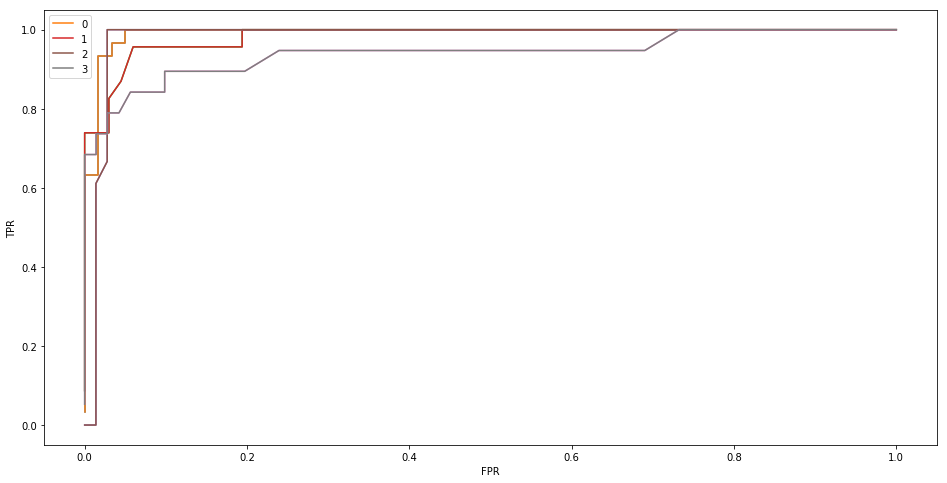

In [11]:
plt.subplots(figsize=(16,8))

#Iterate through the results of the cross_val_predict function using enumerate
for color, sample in enumerate(cv_probs):
    fpr, tpr, thresholds = sme.roc_curve(colors==color+1, sample)
    plt.plot(fpr, tpr)
    plt.plot(fpr, tpr, label = color)


plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR");